In [1]:
import sys
sys.path.append('/Users/jeepark/pair_trading/pair-trading-foundations/')
import ta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#machine learning/statistical dependencies
import statsmodels.api as sm
from kneed import KneeLocator
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.manifold import TSNE
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA 
# from pykalman import KalmanFilter
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
import scipy.cluster.hierarchy as shc
import plotly.express as px
import gc
from collections import defaultdict
import seaborn as sns
import lightgbm as lgb

In [2]:
from pair_trading_foundations.utils import GetSP500Data
import warnings
# The yfinance module has some deprecation warning
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
import requests
session = requests.Session()
session.verify = False
all_data = GetSP500Data('2008-12-01','2023-12-31').get_all_sp_tickers().get_consolidated_data();

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [6]:
final_data = all_data.copy()
final_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,GICS Sector,GICS Sub-Industry
0,2008-12-01,64.949997,66.250000,62.099998,62.349998,38.716515,9715700.0,MMM,Industrials,Industrial Conglomerates
1,2008-12-02,60.700001,62.139999,58.820000,60.860001,37.791306,11934400.0,MMM,Industrials,Industrial Conglomerates
2,2008-12-03,59.660000,61.700001,59.160000,60.709999,37.698158,8972800.0,MMM,Industrials,Industrial Conglomerates
3,2008-12-04,60.130001,60.450001,58.099998,59.139999,36.723270,9290700.0,MMM,Industrials,Industrial Conglomerates
4,2008-12-05,58.209999,60.439999,57.840000,59.849998,37.164139,10272200.0,MMM,Industrials,Industrial Conglomerates


In [7]:
# Examine Null Values in final_data. Examine Date, Close and daily_returns.
final_data.isna().sum()

Date                 0
Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Ticker               0
GICS Sector          0
GICS Sub-Industry    0
dtype: int64

In [9]:
df = final_data.pivot(index='Date', columns='Ticker', values='Close') 
df.head()

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,12.346209,5.12,3.176071,NaN,NaN,24.061970,7.022222,29.059999,21.000000,16.100000,...,33.950001,33.869999,17.690001,74.309998,24.320000,NaN,17.951115,34.378639,18.980000,NaN
2008-12-02,12.618026,6.00,3.302500,NaN,NaN,24.935205,7.370000,30.020000,22.000000,16.350000,...,34.480000,37.580002,17.889999,77.610001,25.160000,NaN,18.138029,35.359222,19.590000,NaN
2008-12-03,13.018598,6.17,3.425000,NaN,NaN,25.501369,7.530000,30.870001,22.540001,17.299999,...,36.189999,40.020000,18.190001,78.930000,25.400000,NaN,19.439253,35.699028,19.500000,NaN
2008-12-04,12.525036,6.65,3.264643,NaN,NaN,24.963993,7.222222,29.129999,20.440001,16.190001,...,35.419998,37.900002,17.570000,76.269997,23.700001,NaN,19.920919,36.029125,18.110001,NaN
2008-12-05,12.346209,7.47,3.357143,NaN,NaN,25.309450,7.572222,28.270000,21.660000,16.660000,...,35.389999,40.610001,18.180000,76.599998,24.730000,NaN,20.848310,36.446602,18.510000,NaN


In [10]:
exp_data = df.copy()

# Null Values are Examined for Each Individual Stock on a Basis of Descriptive Statistics.

print('Null Values =',exp_data.isnull().values.any())

Null Values = True


In [11]:
print('Data Shape Before Cleaning =', exp_data.shape)

missing_percentage = exp_data.isnull().mean().sort_values(ascending=False)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0].index))
print(f"The following is a list of all stocks with ticker-level NA values: \n{dropped_list}")
exp_data.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape After Cleaning =', exp_data.shape)

Data Shape Before Cleaning = (3796, 501)
The following is a list of all stocks with ticker-level NA values: 
['ABBV', 'ABNB', 'ALLE', 'AMCR', 'ANET', 'APTV', 'AVGO', 'CARR', 'CBOE', 'CDW', 'CEG', 'CFG', 'CHTR', 'CPAY', 'CTLT', 'CTVA', 'CZR', 'DAY', 'DG', 'DOW', 'ENPH', 'EPAM', 'ETSY', 'FANG', 'FOX', 'FOXA', 'FTNT', 'FTV', 'GEHC', 'GM', 'GNRC', 'GOOG', 'HCA', 'HII', 'HLT', 'HPE', 'HWM', 'INVH', 'IQV', 'IR', 'KEYS', 'KHC', 'KMI', 'KVUE', 'LW', 'LYB', 'META', 'MPC', 'MRNA', 'NCLH', 'NOW', 'NWS', 'NWSA', 'NXPI', 'OTIS', 'PANW', 'PAYC', 'PSX', 'PYPL', 'QRVO', 'SYF', 'TRGP', 'TSLA', 'UBER', 'VICI', 'VLTO', 'VRSK', 'WRK', 'XYL', 'ZTS']
Data Shape After Cleaning = (3796, 431)


In [12]:
exp_data = exp_data.fillna(exp_data.median()) ### This step to ensure we did not miss any odd days, and if we did, it is standard industry practice to take the median

exp_data['year']=exp_data.index.year

exp_data

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,year
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,12.346209,5.12,3.176071,24.061970,7.022222,29.059999,21.000000,16.100000,25.549999,33.107990,...,57.059605,33.950001,33.869999,17.690001,74.309998,24.320000,17.951115,34.378639,18.980000,2008
2008-12-02,12.618026,6.00,3.302500,24.935205,7.370000,30.020000,22.000000,16.350000,26.120001,33.713783,...,61.139072,34.480000,37.580002,17.889999,77.610001,25.160000,18.138029,35.359222,19.590000,2008
2008-12-03,13.018598,6.17,3.425000,25.501369,7.530000,30.870001,22.540001,17.299999,25.100000,33.854259,...,63.814571,36.189999,40.020000,18.190001,78.930000,25.400000,19.439253,35.699028,19.500000,2008
2008-12-04,12.525036,6.65,3.264643,24.963993,7.222222,29.129999,20.440001,16.190001,24.610001,32.063213,...,62.913906,35.419998,37.900002,17.570000,76.269997,23.700001,19.920919,36.029125,18.110001,2008
2008-12-05,12.346209,7.47,3.357143,25.309450,7.572222,28.270000,21.660000,16.660000,25.830000,33.002632,...,65.430466,35.389999,40.610001,18.180000,76.599998,24.730000,20.848310,36.446602,18.510000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,139.570007,14.31,193.600006,109.029999,73.839996,354.450012,598.750000,197.100006,71.459999,230.970001,...,240.089996,34.360001,90.419998,62.060001,101.910004,35.220001,130.000000,120.559998,269.410004,2023
2023-12-26,139.809998,14.11,193.050003,109.230003,73.510002,353.429993,598.260010,198.869995,72.389999,232.539993,...,239.089996,34.630001,91.000000,62.250000,102.139999,35.540001,130.259995,121.419998,275.500000,2023
2023-12-27,139.820007,13.99,193.149994,109.790001,73.540001,353.820007,596.080017,199.350006,72.169998,231.610001,...,239.300003,34.759998,90.629997,61.540001,101.660004,35.630001,130.839996,121.129997,275.790009,2023


In [13]:
# prepare clustering data by splitting train and test to match trading strategy later

cluster_train_size = int(len(exp_data) * 0.7)

# Split the data into training, validation and test sets based on these lengths:
cluster_train = exp_data[0:cluster_train_size]
print(f"The length of the training set is: {len(cluster_train)}.")

The length of the training set is: 2657.


In [14]:
max(cluster_train.index)

Timestamp('2019-06-21 00:00:00')

In [15]:
cluster_train

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,year
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,12.346209,5.120000,3.176071,24.061970,7.022222,29.059999,21.000000,16.100000,25.549999,33.107990,...,57.059605,33.950001,33.869999,17.690001,74.309998,24.320000,17.951115,34.378639,18.980000,2008
2008-12-02,12.618026,6.000000,3.302500,24.935205,7.370000,30.020000,22.000000,16.350000,26.120001,33.713783,...,61.139072,34.480000,37.580002,17.889999,77.610001,25.160000,18.138029,35.359222,19.590000,2008
2008-12-03,13.018598,6.170000,3.425000,25.501369,7.530000,30.870001,22.540001,17.299999,25.100000,33.854259,...,63.814571,36.189999,40.020000,18.190001,78.930000,25.400000,19.439253,35.699028,19.500000,2008
2008-12-04,12.525036,6.650000,3.264643,24.963993,7.222222,29.129999,20.440001,16.190001,24.610001,32.063213,...,62.913906,35.419998,37.900002,17.570000,76.269997,23.700001,19.920919,36.029125,18.110001,2008
2008-12-05,12.346209,7.470000,3.357143,25.309450,7.572222,28.270000,21.660000,16.660000,25.830000,33.002632,...,65.430466,35.389999,40.610001,18.180000,76.599998,24.730000,20.848310,36.446602,18.510000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-17,70.290001,32.560001,48.472500,82.050003,35.520000,183.899994,275.600006,105.099998,40.740002,165.940002,...,188.279999,25.670000,115.680000,59.880001,75.089996,56.660000,109.160004,114.300972,192.990005,2019
2019-06-18,71.910004,32.520000,49.612499,83.419998,35.779999,184.500000,276.779999,109.940002,41.200001,168.220001,...,188.110001,25.980000,122.000000,60.080002,75.739998,56.840000,108.709999,114.679611,201.809998,2019
2019-06-19,72.650002,33.209999,49.467499,84.330002,36.099998,183.949997,291.209991,111.040001,40.709999,168.250000,...,189.729996,26.059999,122.320000,60.810001,75.320000,57.750000,109.449997,115.893204,200.529999,2019


In [16]:

# calculate average returns by year by stock
returns_year = cluster_train.groupby('year').mean()

# calculate return percent change, then aggregated returns and volatility by stock
returns = returns_year.pct_change().mean()

returns = pd.DataFrame(returns)
returns.columns = ['returns']
returns['volatility'] = returns_year.pct_change().std()



In [17]:
returns

,returns,volatility
Ticker,,
A,0.191869,0.160304
AAL,0.260432,0.568199
AAPL,0.306651,0.309258
ABT,0.114397,0.135614
ACGL,0.150645,0.141961
...,...,...
XOM,0.003392,0.104824
XRAY,0.063990,0.112953
YUM,0.155289,0.094021


In [18]:
ret_data = returns.copy()
ret_data.describe()

,returns,volatility
count,431.000000,431.000000
mean,0.161668,0.200100
std,0.094591,0.113328
min,-0.059046,0.050470
25%,0.101028,0.123290
50%,0.148720,0.168207
75%,0.214923,0.242323
max,0.666682,0.709616


In [19]:
# Standardize The Clustering Dataset Along a t-Distributed Curve
scale = StandardScaler().fit(ret_data)

# Transform the Original Clustering Dataset to These Standardized Values
scaled_data = pd.DataFrame(scale.fit_transform(ret_data),columns = ret_data.columns, index = ret_data.index) 
X = scaled_data
X.describe()

,returns,volatility
count,4.310000e+02,4.310000e+02
mean,-8.861177e-17,-1.092192e-16
std,1.001162e+00,1.001162e+00
min,-2.336062e+00,-1.321861e+00
25%,-6.418159e-01,-6.785513e-01
50%,-1.370349e-01,-2.817536e-01
75%,5.636591e-01,3.730026e-01
max,5.345147e+00,4.501143e+00


In [22]:
n_clusters = 15
random_state = 15

# Algorithm:
# 1. Randomly pick k centroids from the examples ploted above as initial cluster centers (𝜇𝑗,𝑗∈1,...,𝑘)
# 2. Assign each example to the nearest centroid,  𝜇𝑗
# 3. Move the centroids to the center of the examples that were assigned to it
# 4. Repeat (2-3) until the cluster assignments do not change or a maximum number of iterations is reached.

def fit_kmeans(X, n_clusters, random_state):

    kmeans = KMeans(n_clusters=n_clusters,
                    init='k-means++',
                    n_init=15,
                    max_iter=300,
                    tol=1e-04)
    model = kmeans.fit(X)
    return model

model = fit_kmeans(X, n_clusters, random_state)
print(model)

## get cluster prediction and add to DataFrame
kX = X.copy()
kX['cluster'] = model.predict(X)
kX

KMeans(n_clusters=15, n_init=15)


,returns,volatility,cluster
Ticker,,,
A,0.319657,-0.351563,13
AAL,1.045332,3.251847,14
AAPL,1.534527,0.964317,4
ABT,-0.500316,-0.569680,9
ACGL,-0.116668,-0.513612,9
...,...,...,...
XOM,-1.675209,-0.841682,5
XRAY,-1.033829,-0.769873,5
YUM,-0.067514,-0.937120,3


In [23]:
kX['cluster'].value_counts()

13    66
9     66
3     55
5     50
2     43
0     32
7     26
6     22
4     21
8     21
14    10
1      8
10     6
12     4
11     1
Name: cluster, dtype: int64

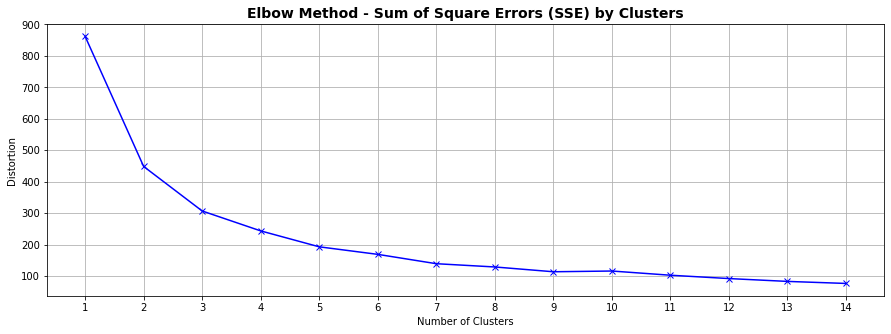

In [27]:
# The Elbow Method

distortions = []
max_loop = 15
sse = {}

for k in range(1, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    sse[k] = kmeans.inertia_

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, max_loop), distortions, 'bx-')
plt.title("Elbow Method - Sum of Square Errors (SSE) by Clusters", fontsize=14, color="black", fontweight="bold")
plt.xticks([i for i in range(1, max_loop)], rotation=0)
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.grid(True)

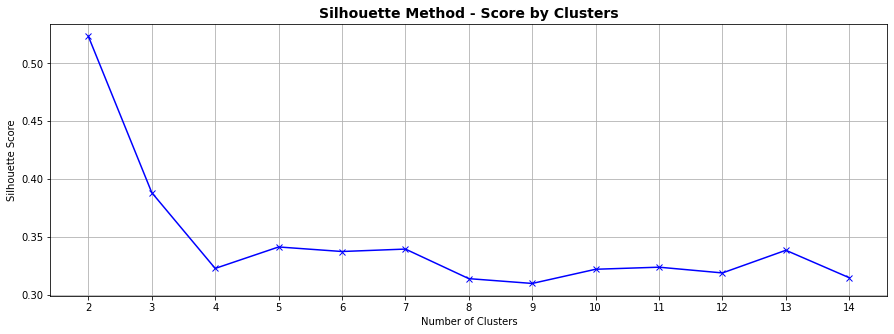

In [29]:
# The Silhouette Method:

#For the silhouette method k needs to start from 2

silhouette_score = []
max_loop = 15
sse = {}

for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(returns, kmeans.labels_))
        sse[k] = kmeans.inertia_
        
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score, 'bx-')
plt.title("Silhouette Method - Score by Clusters", fontsize=14, color="black", fontweight="bold")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks([i for i in range(2, max_loop)], rotation=0)
plt.grid(True)

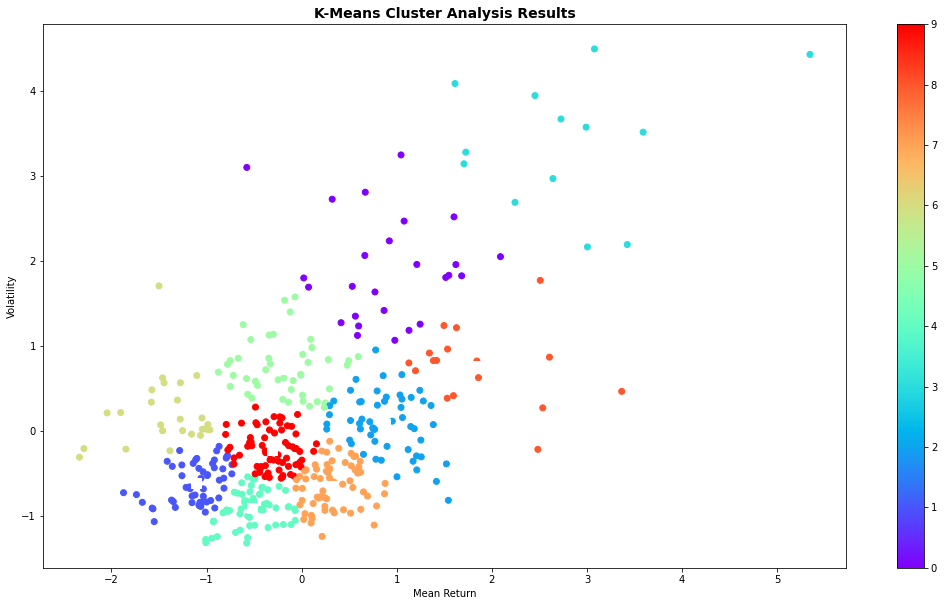

In [32]:
# c = kn.knee   # Number of clusters
c = 10   # Number of clusters - based on elbow method slope

#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = returns.index)
ax.set_title('K-Means Cluster Analysis Results', fontsize=14, color='black', fontweight='bold')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sw',markersize=10)
plt.show()

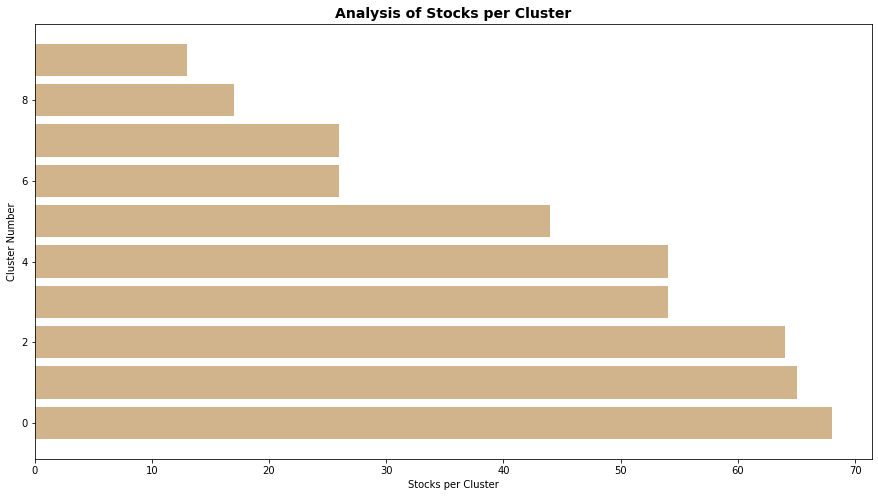

In [33]:
# Plot number of stocks per cluster

clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(15,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts(), color='tan')
plt.title('Analysis of Stocks per Cluster', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()


In [34]:
counts = clustered_series.value_counts()

cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

clust1 = pd.DataFrame(clustered_series,columns=['label'])
grouped_df = clust1.groupby('label')

In [35]:
final_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,GICS Sector,GICS Sub-Industry
0,2008-12-01,64.949997,66.250000,62.099998,62.349998,38.716515,9715700.0,MMM,Industrials,Industrial Conglomerates
1,2008-12-02,60.700001,62.139999,58.820000,60.860001,37.791306,11934400.0,MMM,Industrials,Industrial Conglomerates
2,2008-12-03,59.660000,61.700001,59.160000,60.709999,37.698158,8972800.0,MMM,Industrials,Industrial Conglomerates
3,2008-12-04,60.130001,60.450001,58.099998,59.139999,36.723270,9290700.0,MMM,Industrials,Industrial Conglomerates
4,2008-12-05,58.209999,60.439999,57.840000,59.849998,37.164139,10272200.0,MMM,Industrials,Industrial Conglomerates


In [36]:
final_data_train = final_data.copy()
final_data_train = final_data_train.loc[final_data_train.Date <= max(cluster_train.index)]

In [37]:
final_data_train

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,GICS Sector,GICS Sub-Industry
0,2008-12-01,64.949997,66.250000,62.099998,62.349998,38.716515,9715700.0,MMM,Industrials,Industrial Conglomerates
1,2008-12-02,60.700001,62.139999,58.820000,60.860001,37.791306,11934400.0,MMM,Industrials,Industrial Conglomerates
2,2008-12-03,59.660000,61.700001,59.160000,60.709999,37.698158,8972800.0,MMM,Industrials,Industrial Conglomerates
3,2008-12-04,60.130001,60.450001,58.099998,59.139999,36.723270,9290700.0,MMM,Industrials,Industrial Conglomerates
4,2008-12-05,58.209999,60.439999,57.840000,59.849998,37.164139,10272200.0,MMM,Industrials,Industrial Conglomerates
...,...,...,...,...,...,...,...,...,...,...
1800721,2019-06-17,110.959999,111.250000,110.040001,110.809998,107.257072,1726700.0,ZTS,Health Care,Pharmaceuticals
1800722,2019-06-18,111.169998,113.489998,110.720001,113.379997,109.744698,2572900.0,ZTS,Health Care,Pharmaceuticals
1800723,2019-06-19,113.330002,114.449997,113.029999,114.279999,110.615822,2026700.0,ZTS,Health Care,Pharmaceuticals
1800724,2019-06-20,115.330002,116.470001,112.809998,112.970001,109.347824,3083300.0,ZTS,Health Care,Pharmaceuticals


In [38]:
pivot_data = final_data_train.pivot(index='Ticker', columns='Date', values='Adj Close')
pivot_data.head()

Date,2008-12-01,2008-12-02,2008-12-03,2008-12-04,2008-12-05,2008-12-08,2008-12-09,2008-12-10,2008-12-11,2008-12-12,...,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21
Ticker,,,,,,,,,,,,,,,,,,,,,
A,11.114177,11.358872,11.719474,11.275161,11.114177,11.101300,11.545614,11.713033,11.674395,11.197891,...,67.958725,67.765350,67.958725,67.968407,67.649353,67.958725,69.524994,70.240440,70.888245,70.907555
AAL,4.826836,5.656448,5.816714,6.269231,7.042278,7.438231,6.429496,6.882012,6.146675,6.297513,...,30.440653,30.262520,30.777122,32.746460,32.340717,32.221966,32.182377,32.865215,31.816221,31.242243
AAPL,2.688860,2.795895,2.899603,2.763845,2.842156,3.015105,3.025383,2.969448,2.872391,2.971262,...,46.527630,47.066395,46.916603,46.906940,46.566284,46.844120,47.945831,47.805695,48.189850,48.025555
ABBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.897575,62.878922,63.200691,63.506355,63.297199,63.265026,62.943275,62.428478,63.015675,63.369614
ABT,16.965698,17.581404,17.980606,17.601706,17.845284,17.902800,17.581404,17.429173,17.263405,17.168688,...,75.022552,74.884079,75.650269,75.964134,75.899498,75.742592,77.007263,77.847321,78.410400,78.465805


In [40]:
# cluster evaluation and model selection
cluster_size_limit = 9999
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 10
Number of Pairs: 22092


In [41]:
# Provide a functional definition for the cointegrated augmented dickey fuller test
def find_cadf_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = {}
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            ols = sm.OLS(S1,S2).fit()
            pred = ols.predict(S2)
            adf = ts.adfuller(S1-pred)
            score = adf[0]
            pvalue = adf[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.03:
                pairs[(keys[i], keys[j])] = adf
    return score_matrix, pvalue_matrix, pairs

In [42]:
# Extract Cointegrated Pairs. This takes approximately 30-40 minutes. Again, this would take much longer if clustering analysis was not applied.
adf_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, adf_pairs = find_cadf_pairs(cluster_train[tickers])
    adf_dict[clust] = {}
    adf_dict[clust]['score_matrix'] = score_matrix
    adf_dict[clust]['pvalue_matrix'] = pvalue_matrix
    adf_dict[clust]['pairs'] = adf_pairs
    
adf_pairs = []   
for cluster in adf_dict.keys():
    adf_pairs.extend(adf_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(adf_pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(adf_pairs)))
print(adf_pairs)

Number of pairs: 987
In those pairs, we found 357 unique tickers.
[('ACGL', 'AIZ'), ('ACGL', 'HOLX'), ('ACGL', 'LOW'), ('AFL', 'DE'), ('AFL', 'DOV'), ('AFL', 'GRMN'), ('AFL', 'MTB'), ('AFL', 'PH'), ('AIZ', 'AMGN'), ('AIZ', 'HAS'), ('AIZ', 'HIG'), ('AIZ', 'HOLX'), ('AIZ', 'LOW'), ('AIZ', 'MAS'), ('AIZ', 'MCHP'), ('AIZ', 'PNC'), ('AIZ', 'TEL'), ('ALL', 'AMGN'), ('ALL', 'BLK'), ('ALL', 'GL'), ('ALL', 'LOW'), ('ALL', 'MAS'), ('ALL', 'MCHP'), ('ALL', 'PNC'), ('ALL', 'RJF'), ('ALL', 'SCHW'), ('ALL', 'TEL'), ('ALL', 'TXT'), ('AMGN', 'HIG'), ('AMGN', 'KEY'), ('AMGN', 'LOW'), ('AMGN', 'PPG'), ('AMGN', 'SNA'), ('AMGN', 'TXT'), ('AVY', 'CME'), ('AVY', 'JPM'), ('AVY', 'MAS'), ('AVY', 'NDAQ'), ('BIO', 'CME'), ('BIO', 'JPM'), ('BIO', 'NSC'), ('BLK', 'HIG'), ('BLK', 'KEY'), ('BLK', 'PNC'), ('BLK', 'TXT'), ('CCL', 'DD'), ('CME', 'CSCO'), ('COF', 'CPT'), ('COF', 'DD'), ('COF', 'EOG'), ('COF', 'ETN'), ('COF', 'HUBB'), ('COF', 'IP'), ('COF', 'JBHT'), ('COF', 'KEY'), ('COF', 'MTB'), ('COF', 'PRU'), ('COF'

In [54]:
top500_pairs = list(map(list, adf_pairs))
top500_pairs = [lst for lst in top500_pairs if lst and not any(x is None for x in lst)]
top500_pairs

[['ACGL', 'AIZ'],
 ['ACGL', 'HOLX'],
 ['ACGL', 'LOW'],
 ['AFL', 'DE'],
 ['AFL', 'DOV'],
 ['AFL', 'GRMN'],
 ['AFL', 'MTB'],
 ['AFL', 'PH'],
 ['AIZ', 'AMGN'],
 ['AIZ', 'HAS'],
 ['AIZ', 'HIG'],
 ['AIZ', 'HOLX'],
 ['AIZ', 'LOW'],
 ['AIZ', 'MAS'],
 ['AIZ', 'MCHP'],
 ['AIZ', 'PNC'],
 ['AIZ', 'TEL'],
 ['ALL', 'AMGN'],
 ['ALL', 'BLK'],
 ['ALL', 'GL'],
 ['ALL', 'LOW'],
 ['ALL', 'MAS'],
 ['ALL', 'MCHP'],
 ['ALL', 'PNC'],
 ['ALL', 'RJF'],
 ['ALL', 'SCHW'],
 ['ALL', 'TEL'],
 ['ALL', 'TXT'],
 ['AMGN', 'HIG'],
 ['AMGN', 'KEY'],
 ['AMGN', 'LOW'],
 ['AMGN', 'PPG'],
 ['AMGN', 'SNA'],
 ['AMGN', 'TXT'],
 ['AVY', 'CME'],
 ['AVY', 'JPM'],
 ['AVY', 'MAS'],
 ['AVY', 'NDAQ'],
 ['BIO', 'CME'],
 ['BIO', 'JPM'],
 ['BIO', 'NSC'],
 ['BLK', 'HIG'],
 ['BLK', 'KEY'],
 ['BLK', 'PNC'],
 ['BLK', 'TXT'],
 ['CCL', 'DD'],
 ['CME', 'CSCO'],
 ['COF', 'CPT'],
 ['COF', 'DD'],
 ['COF', 'EOG'],
 ['COF', 'ETN'],
 ['COF', 'HUBB'],
 ['COF', 'IP'],
 ['COF', 'JBHT'],
 ['COF', 'KEY'],
 ['COF', 'MTB'],
 ['COF', 'PRU'],
 ['COF', 'RHI'],

In [46]:
# Modification of the ADF test from earlier to apply to the top pairs in each cluster. Pulling out the p-value only.
def find_cadf_pairs_validate(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = {}
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            ols = sm.OLS(S1,S2).fit()
            pred = ols.predict(S2)
            adf = ts.adfuller(S1-pred)
            score = adf[0]
            pvalue = adf[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs[(keys[i], keys[j])] = adf
    pvalue_result = min(pvalue_matrix[0])
    return pvalue_result

In [72]:
# loop the best cluster list to filter exp_data df
# loop the filtered df through find_cadf_pairs_validate function to retrieve the pvalue_result
# append the pvalue_result to a new dataframe to rank the best pair based on p-value

def cluster_ranking(data):
    n = len(data)
    cluster_ranked = pd.DataFrame({'ticker1':[],'ticker2':[],'pvalue':[]})
    for i in range(n):
        pair_validate_df=exp_data.filter(items=data[i])
        p_value = find_cadf_pairs_validate(pair_validate_df)
        new_row = {'ticker1':top500_pairs[i][0],'ticker2':top500_pairs[i][1],'pvalue': p_value}
        cluster_ranked = cluster_ranked.append(new_row,ignore_index=True)
        new_row = {}
    cluster_ranked = cluster_ranked.sort_values(by='pvalue')
    return cluster_ranked


In [73]:
# display the best pair from each cluster, sorted by the lowest p-value
top500_df = cluster_ranking(top500_pairs)

In [74]:
top500_df

,ticker1,ticker2,pvalue
443,ADP,WM,0.000005
485,ATO,BDX,0.000007
971,C,GEN,0.000007
974,DVN,MOS,0.000008
439,ADP,AON,0.000014
...,...,...,...
607,LLY,MKC,1.000000
59,CPT,ETN,1.000000
288,DHI,FIS,1.000000
900,PWR,VZ,1.000000


In [75]:
top500_df = top500_df[0:500]

In [91]:
top500_df = top500_df.reset_index()

In [70]:
top500_df.to_csv('top500pairs.csv')

In [92]:
top10_df = top500_df[0:10]

In [93]:
top10_df

,index,ticker1,ticker2,pvalue
0,443,ADP,WM,0.000005
1,485,ATO,BDX,0.000007
2,971,C,GEN,0.000007
3,974,DVN,MOS,0.000008
4,439,ADP,AON,0.000014
5,550,DUK,KO,0.000022
6,17,ALL,AMGN,0.000024
7,13,AIZ,MAS,0.000038
8,612,LNT,SYY,0.000044
9,347,GPN,TFX,0.000056


In [77]:
# loop the best cluster list to filter exp_data df
# loop the filtered df through find_cadf_pairs_validate function to retrieve the pvalue_result
# append the pvalue_result to a new dataframe to rank the best pair based on p-value

def create_timeseries_rankedpairs(data):
    n = len(data)
    for i in range(n):
        pair_df=cluster_train.filter(items=[data['ticker1'][i],data['ticker2'][i]])
        pair_df.iloc[:,0].plot(figsize=(15,7), legend = True, label = data['ticker1'][i])
        pair_df.iloc[:,1].plot(figsize=(15,7), legend = True, label = data['ticker2'][i])
        plt.ylabel('Price $')
        plt.xlabel('Date')
        plt.title('Daily Close Price', fontsize=14, color="black", fontweight="bold")
        plt.show()
        

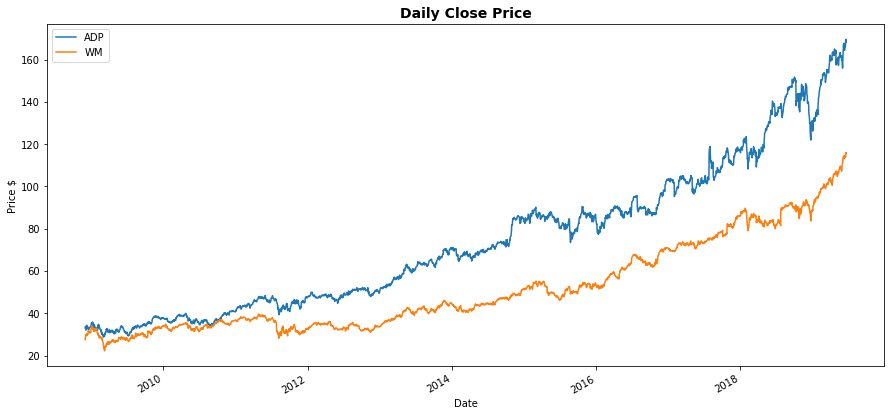

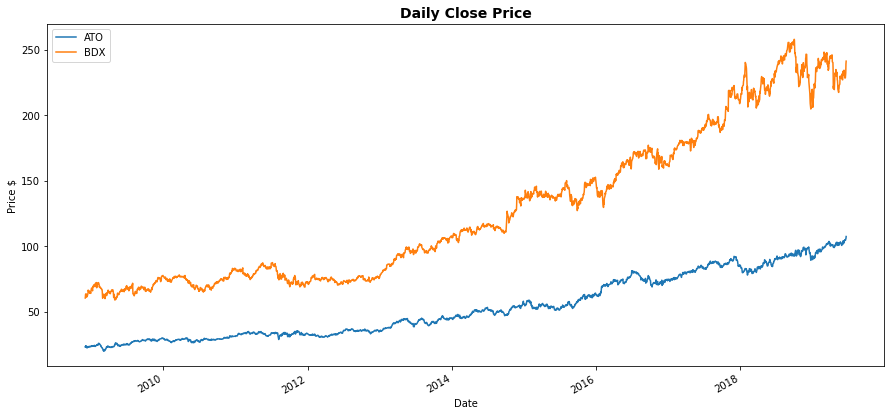

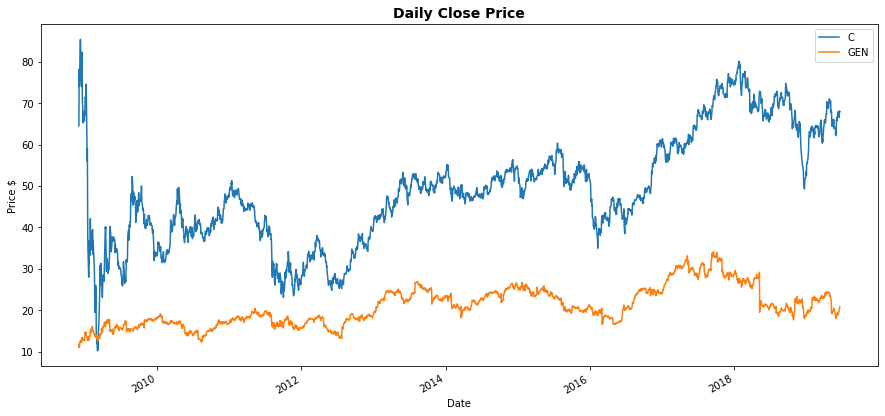

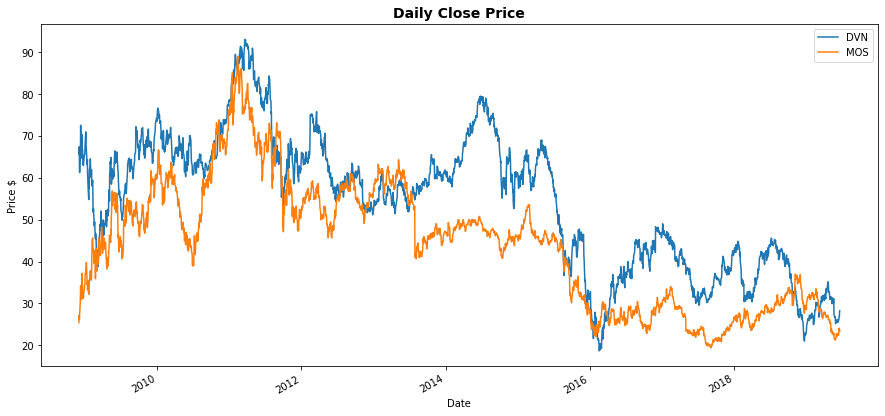

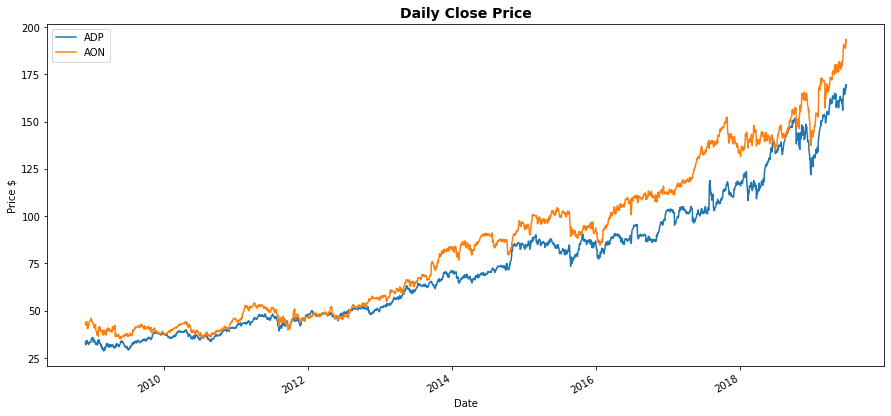

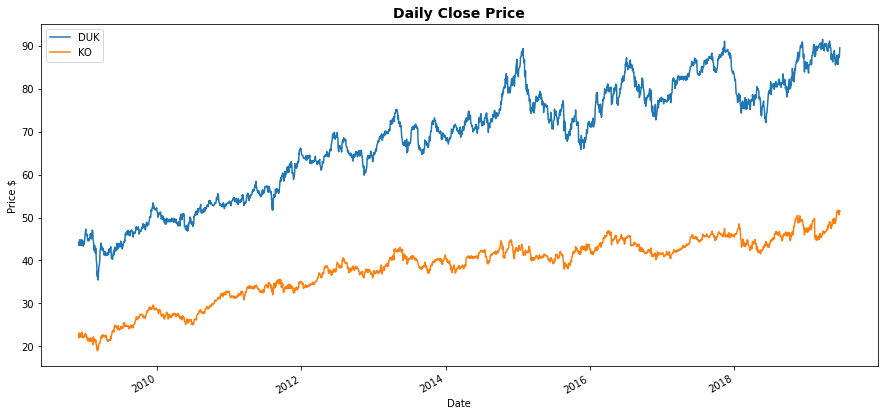

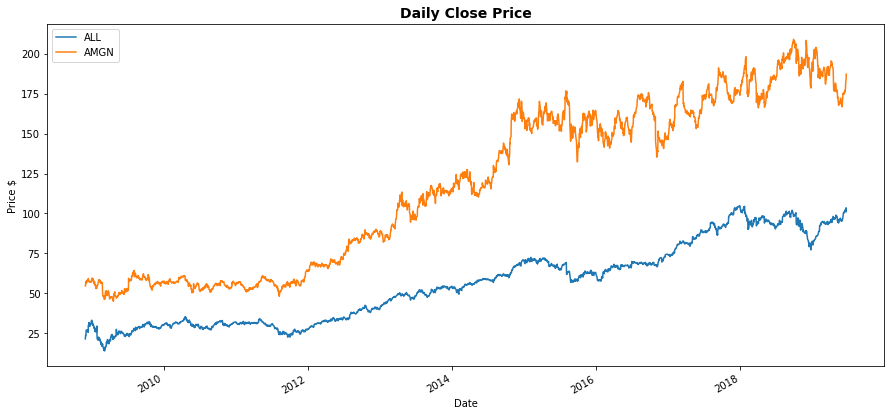

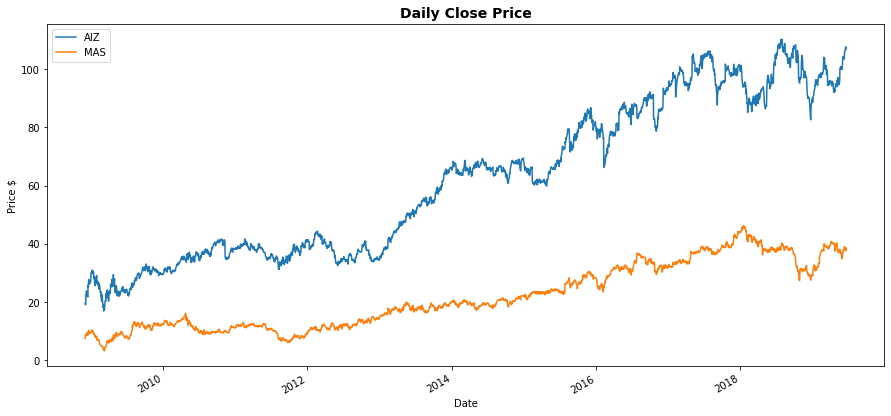

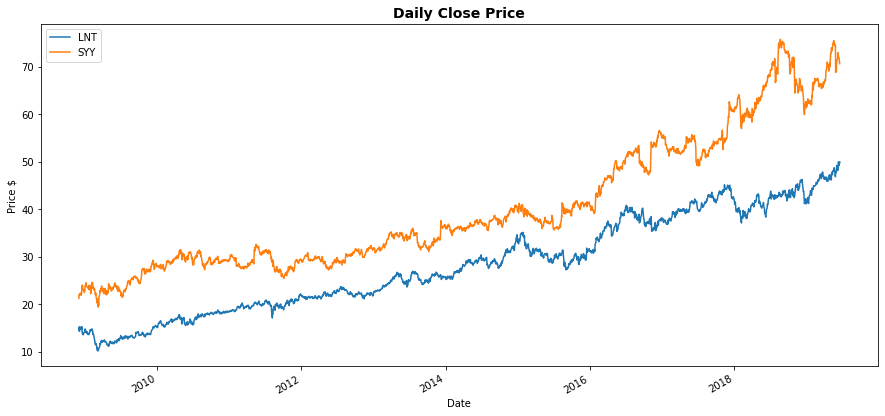

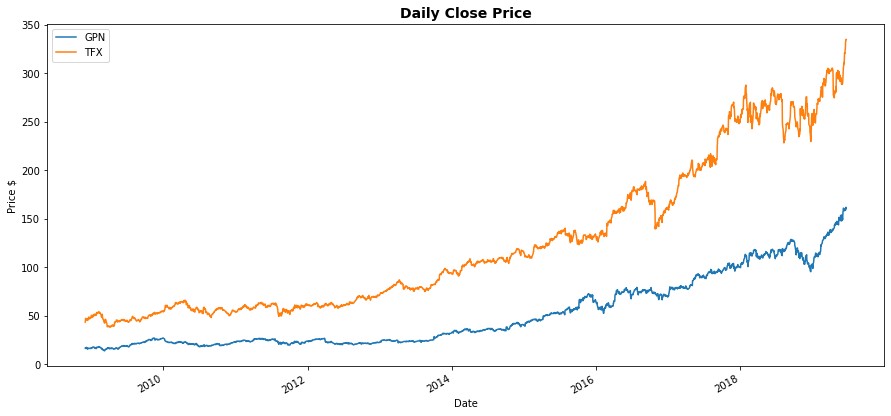

In [94]:
create_timeseries_rankedpairs(top10_df)